In [1]:
import zipfile

zip_path = "object.zip"     
extract_path = "object"      

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("Unzipped successfully!")


Unzipped successfully!


In [7]:
import os

INPUT_DIR = "object"

print("Current working directory:")
print(os.getcwd())

print("\nContents of INPUT_DIR:")
print(os.listdir(INPUT_DIR))


Current working directory:
C:\Users\pc

Contents of INPUT_DIR:
['object']


In [8]:
INPUT_DIR = "object/object"


In [18]:
for cls in os.listdir(INPUT_DIR):
    print(cls, "->", os.listdir(os.path.join(INPUT_DIR, cls))[:15])


object -> ['ibis', 'inline_skate', 'joshua_tree', 'kangaroo', 'ketch', 'lamp', 'laptop', 'Leopards', 'llama', 'lobster', 'lotus', 'mandolin', 'mayfly', 'menorah', 'metronome']


In [20]:
import os

INPUT_DIR = "object/object"

print("INPUT_DIR exists?", os.path.exists(INPUT_DIR))
print("Folders inside INPUT_DIR:")
print(os.listdir(INPUT_DIR))

for cls in os.listdir(INPUT_DIR):
    cls_path = os.path.join(INPUT_DIR, cls)
    if os.path.isdir(cls_path):
        print(cls, "images:", len(os.listdir(cls_path)))


INPUT_DIR exists? True
Folders inside INPUT_DIR:
['object']
object images: 51


In [23]:
import os

INPUT_DIR = "object/object"

print("Classes found:")
print(os.listdir(INPUT_DIR))

for cls in os.listdir(INPUT_DIR):
    cls_path = os.path.join(INPUT_DIR, cls)
    if os.path.isdir(cls_path):
        print("\nClass:", cls)
        print("Files:", os.listdir(cls_path)[:12])


Classes found:
['object']

Class: object
Files: ['ibis', 'inline_skate', 'joshua_tree', 'kangaroo', 'ketch', 'lamp', 'laptop', 'Leopards', 'llama', 'lobster', 'lotus', 'mandolin']


In [24]:
import os
from PIL import Image
from collections import defaultdict
import shutil

INPUT_DIR = "object/object"
OUTPUT_DIR = "balanced_dataset"
IMG_SIZE = 128
RESAMPLE = Image.LANCZOS

# Reset output
if os.path.exists(OUTPUT_DIR):
    shutil.rmtree(OUTPUT_DIR)
os.makedirs(OUTPUT_DIR)

class_images = defaultdict(list)

# ✅ WALK THROUGH ALL SUBFOLDERS (ROBUST)
for root, dirs, files in os.walk(INPUT_DIR):
    for file in files:
        if file.lower().endswith((".jpg", ".jpeg", ".png", ".bmp", ".webp")):
            class_name = os.path.basename(root)
            class_images[class_name].append(os.path.join(root, file))

# DEBUG PRINT
print("Classes & image counts:")
for k, v in class_images.items():
    print(k, "->", len(v))

# SAFETY CHECK
if len(class_images) == 0:
    raise ValueError("❌ No images found at all. Dataset structure incorrect.")

# Balance
min_count = min(len(v) for v in class_images.values())
print(f"\nBalancing all classes to {min_count} images")

# Resize + save
for cls, images in class_images.items():
    out_cls_dir = os.path.join(OUTPUT_DIR, cls)
    os.makedirs(out_cls_dir, exist_ok=True)

    for i, img_path in enumerate(images[:min_count]):
        try:
            img = Image.open(img_path).convert("RGB")
            img.thumbnail((IMG_SIZE, IMG_SIZE), RESAMPLE)

            canvas = Image.new("RGB", (IMG_SIZE, IMG_SIZE), (0, 0, 0))
            x = (IMG_SIZE - img.width) // 2
            y = (IMG_SIZE - img.height) // 2
            canvas.paste(img, (x, y))

            canvas.save(
                os.path.join(out_cls_dir, f"{i+1:04d}.jpg"),
                quality=95
            )
        except Exception as e:
            print("Skipping:", img_path, e)

print("\n✅ Dataset resized & balanced successfully!")



Classes & image counts:
ibis -> 80
inline_skate -> 31
joshua_tree -> 64
kangaroo -> 86
ketch -> 114
lamp -> 61
laptop -> 81
Leopards -> 200
llama -> 78
lobster -> 41
lotus -> 66
mandolin -> 43
mayfly -> 80
menorah -> 87
metronome -> 32
minaret -> 76
Motorbikes -> 798
nautilus -> 55
octopus -> 35
okapi -> 39
pagoda -> 47
panda -> 38
pigeon -> 45
pizza -> 53
platypus -> 34
pyramid -> 57
revolver -> 82
rhino -> 59
rooster -> 49
saxophone -> 40
schooner -> 63
scissors -> 39
scorpion -> 84
sea_horse -> 57
snoopy -> 35
soccer_ball -> 64
stapler -> 45
starfish -> 86
stegosaurus -> 59
stop_sign -> 64
strawberry -> 35
sunflower -> 85
tick -> 49
trilobite -> 86
umbrella -> 75
watch -> 239
water_lilly -> 37
wheelchair -> 59
wild_cat -> 34
windsor_chair -> 56
wrench -> 39

Balancing all classes to 31 images

✅ Dataset resized & balanced successfully!


In [25]:
!pip install tensorflow


In [26]:
import tensorflow as tf
print(tf.__version__)


C:\Users\pc\anaconda3\Lib\site-packages\keras\src\export\tf2onnx_lib.py:8: FutureWarning: In the future `np.object` will be defined as the corresponding NumPy scalar.
  if not hasattr(np, "object"):


2.20.0


In [27]:
import os
import numpy as np
from PIL import Image

DATASET_DIR = "balanced_dataset"
IMG_SIZE = (128, 128)

X = []
y = []

class_names = sorted(os.listdir(DATASET_DIR))
class_to_label = {cls: idx for idx, cls in enumerate(class_names)}

for cls in class_names:
    cls_path = os.path.join(DATASET_DIR, cls)
    for file in os.listdir(cls_path):
        if file.lower().endswith(".jpg"):
            img = Image.open(os.path.join(cls_path, file)).convert("RGB")
            img = img.resize(IMG_SIZE)
            X.append(np.array(img))
            y.append(class_to_label[cls])

X = np.array(X, dtype=np.uint8)
y = np.array(y)

print("Images:", X.shape)
print("Classes:", len(class_names))


Images: (1581, 128, 128, 3)
Classes: 51


In [28]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tqdm import tqdm

model = ResNet50(weights="imagenet", include_top=False, pooling="avg")

features = []
batch_size = 32

for i in tqdm(range(0, len(X), batch_size)):
    batch = X[i:i+batch_size]
    batch_resized = []

    for img in batch:
        img = Image.fromarray(img).resize((224,224))
        batch_resized.append(np.array(img))

    batch_resized = preprocess_input(np.array(batch_resized))
    features.append(model.predict(batch_resized, verbose=0))

features = np.vstack(features)
print("Feature shape:", features.shape)


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [02:36<00:00,  3.13s/it]

Feature shape: (1581, 2048)


In [29]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
features_norm = scaler.fit_transform(features)

print("Features normalized")


Features normalized


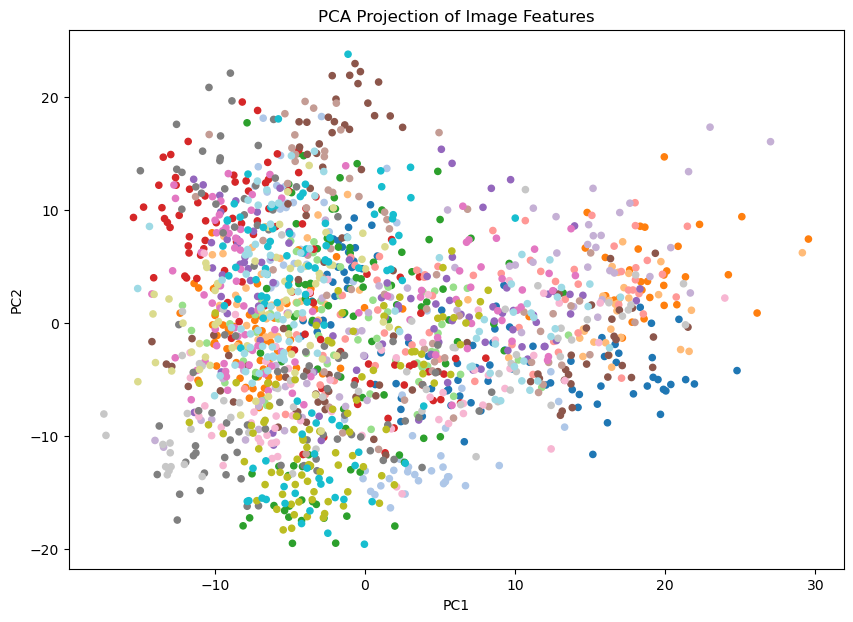

In [30]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

pca = PCA(n_components=2)
features_2d = pca.fit_transform(features_norm)

plt.figure(figsize=(10,7))
plt.scatter(features_2d[:,0], features_2d[:,1], c=y, cmap="tab20", s=20)
plt.title("PCA Projection of Image Features")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()


Silhouette Score: 0.089137904
Davies Bouldin Score: 2.586651924136601


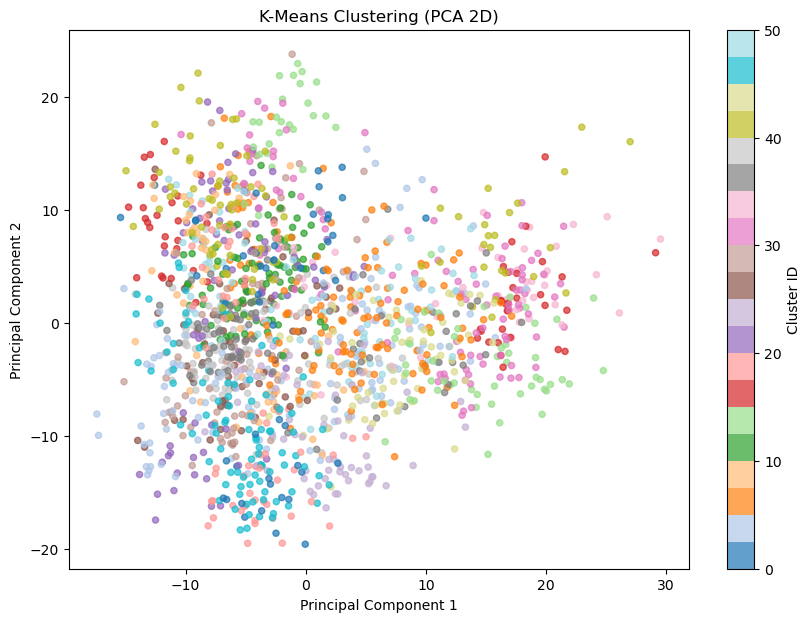

In [36]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score
import matplotlib.pyplot as plt

# Number of clusters = number of classes
k = len(np.unique(y))

kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
cluster_labels = kmeans.fit_predict(features_norm)

print("Silhouette Score:", silhouette_score(features_norm, cluster_labels))
print("Davies Bouldin Score:", davies_bouldin_score(features_norm, cluster_labels))

# ===== VISUALIZATION =====
plt.figure(figsize=(10,7))
plt.scatter(
    features_2d[:, 0],
    features_2d[:, 1],
    c=cluster_labels,
    cmap="tab20",
    s=20,
    alpha=0.7
)
plt.title("K-Means Clustering (PCA 2D)")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.colorbar(label="Cluster ID")
plt.show()


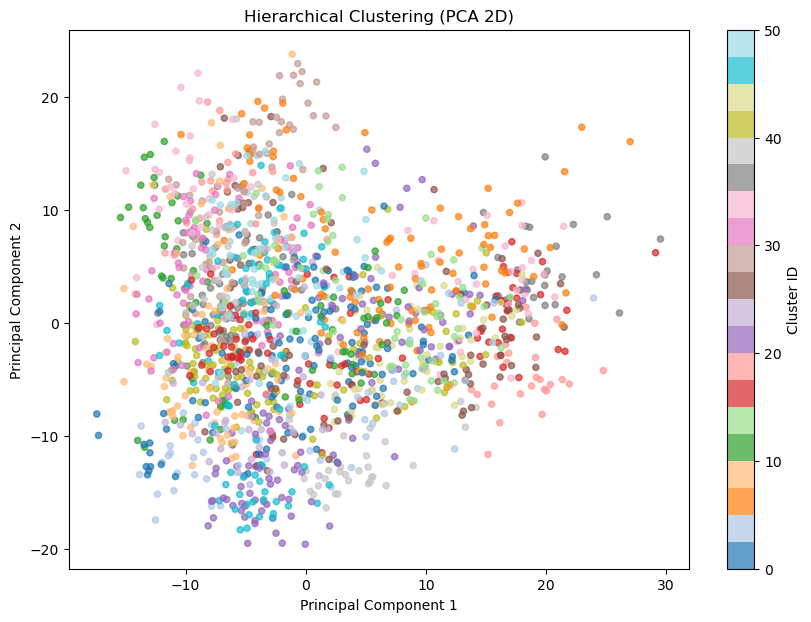

In [37]:
from sklearn.cluster import AgglomerativeClustering

# Use subset (hierarchical heavy hota hai)
subset_size = 2000
features_hier = features_norm[:subset_size]

hier = AgglomerativeClustering(n_clusters=k, linkage="ward")
hier_labels = hier.fit_predict(features_hier)

# ===== VISUALIZATION =====
plt.figure(figsize=(10,7))
plt.scatter(
    features_2d[:subset_size, 0],
    features_2d[:subset_size, 1],
    c=hier_labels,
    cmap="tab20",
    s=20,
    alpha=0.7
)
plt.title("Hierarchical Clustering (PCA 2D)")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.colorbar(label="Cluster ID")
plt.show()



Train samples: 1264
Test samples: 317

🔹 SVM Classification Report:

               precision    recall  f1-score   support

     Leopards     1.0000    1.0000    1.0000         6
   Motorbikes     1.0000    1.0000    1.0000         6
         ibis     1.0000    0.8333    0.9091         6
 inline_skate     1.0000    1.0000    1.0000         6
  joshua_tree     1.0000    0.8333    0.9091         6
     kangaroo     1.0000    0.8333    0.9091         6
        ketch     0.8333    0.8333    0.8333         6
         lamp     0.8750    1.0000    0.9333         7
       laptop     1.0000    1.0000    1.0000         6
        llama     1.0000    0.8333    0.9091         6
      lobster     1.0000    0.8571    0.9231         7
        lotus     0.6250    0.8333    0.7143         6
     mandolin     1.0000    0.8333    0.9091         6
       mayfly     1.0000    1.0000    1.0000         6
      menorah     1.0000    0.8571    0.9231         7
    metronome     1.0000    1.0000    1.0000      

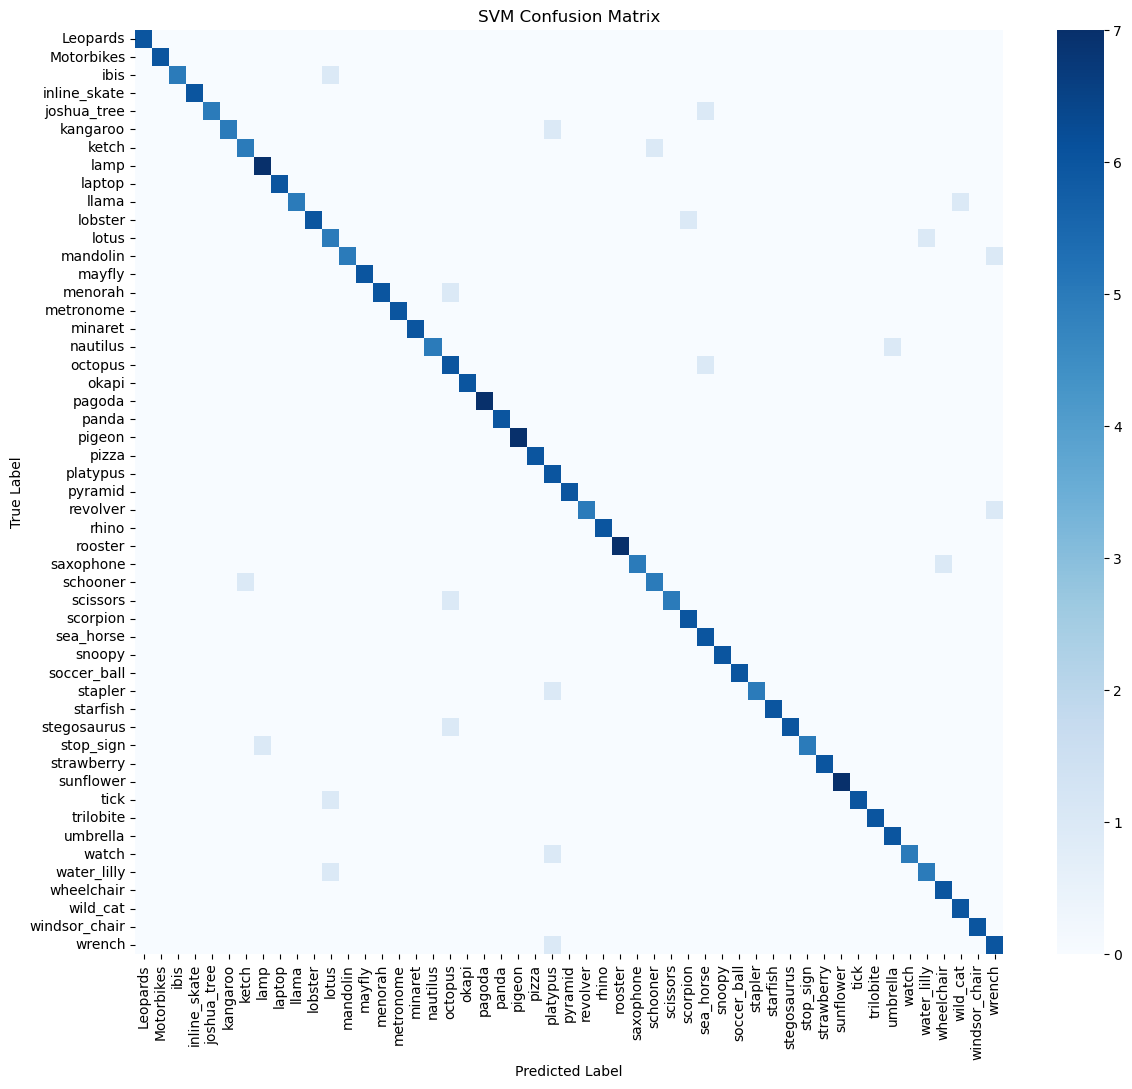

In [35]:
# ==============================
# STEP-7: SVM CLASSIFICATION + EVALUATION
# ==============================

from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    features_norm,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print("Train samples:", X_train.shape[0])
print("Test samples:", X_test.shape[0])

# Train SVM
svm = SVC(
    kernel="rbf",
    C=10,
    gamma="scale",
    random_state=42
)

svm.fit(X_train, y_train)

# Predictions
y_pred = svm.predict(X_test)

# ===== CLASSIFICATION REPORT =====
print("\n🔹 SVM Classification Report:\n")
print(classification_report(
    y_test,
    y_pred,
    target_names=class_names,
    digits=4
))

# ===== CONFUSION MATRIX =====
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(14,12))
sns.heatmap(
    cm,
    cmap="Blues",
    xticklabels=class_names,
    yticklabels=class_names
)
plt.title("SVM Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.show()



In [43]:
np.save("images_array.npy", X)
np.save("resnet50_features.npy", features_norm)


In [44]:
import shutil

shutil.copy("images_array.npy", r"C:\Users\pc\Desktop\ml\images_array.npy")
shutil.copy("resnet50_features.npy", r"C:\Users\pc\Desktop\ml\resnet50_features.npy")


'C:\\Users\\pc\\Desktop\\ml\\resnet50_features.npy'